### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, cross_val_predict, RepeatedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from model_analysis import get_report_model,get_test_train_data

from models_analysis.raw_scaled_data import get_raw_scaled_data
from models_analysis.classic_models_evaluation import get_models_to_evaluate
from models_analysis.utils import get_graph_matrix

import time
SIZE_SAMPLE = 80

Load data

In [2]:
dataset = pd.read_pickle('./model_data/patterns_dataset.pkl')

Results final table

In [3]:
results = [] ## Acumulate scores for final table

Labels

In [4]:
le = LabelEncoder()
labels = le.fit_transform(dataset['pattern'])
y = labels

Functions

In [5]:
def save_model_results(result, model_name, data_type, params, results):
    result = {"name":model_name, "data":data_type, "acc":result[0],
          "precision":result[1], "recall":result[2],
          "roc":result[3],"f1":result[4], "time":result[5],
          "params":params}
    results.append(result)

In [6]:
time_series = get_raw_scaled_data(dataset)

In [7]:
models = get_models_to_evaluate()

In [8]:
start_time_global = time.time()

In [9]:
outer_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=420)

In [10]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score


df_scores = None

def get_report_model_cv(model, X, y):
    
    start = time.time()
    scores_arr=[]
    
    global df_scores
    
    roc_auc_ovr_macro = make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)


    scoring = {'acc': 'accuracy',
               'prec_macro': 'precision_macro',
               'rec_macro': 'recall_macro',
               'f1':'f1_macro',
               'roc':roc_auc_ovr_macro}

    scores = cross_validate(model, X, y, scoring=scoring,
                         cv=outer_cv, return_train_score=True, n_jobs=-1)

    df_scores = pd.DataFrame(scores)
    scores_arr.append(df_scores)

    total_seconds = time.time() - start
    hours, minutes, seconds = get_time(total_seconds)
    print(f'It took {hours} hours {minutes} minutes {seconds} seconds')
    concat_result = pd.concat(scores_arr) 
    
    accuracy = concat_result['test_acc'].mean()
    precision = concat_result['test_prec_macro'].mean()
    recall = concat_result['test_rec_macro'].mean()
    f1 = concat_result['test_f1'].mean()
    roc = concat_result['test_roc'].mean()
    print(f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")

    return accuracy, precision, recall, roc, f1, total_seconds

In [11]:
def get_time(difference):
    hours=difference//(60*60)
    minutes=(difference//60)%60
    seconds = difference%60
  
    return hours, minutes, seconds

## Model evaluation

In [12]:
for model_default in models:
    print(f"\n=========== Model: {model_default.name} ==========")
    for x_data in time_series:
        print(f"****** data: {x_data.name} ******")
        model_def = model_default.model(probability=True) if model_default.name == "SVC" else model_default.model()
        accuracy, precision, recall, roc, f1, total_seconds = get_report_model_cv(model_def, x_data.data, y)
        result = [accuracy, precision, recall, f1, roc, total_seconds]
        save_model_results(result, model_default.name, x_data.name, 'default', results)


=========== Model: KNN ==========
****** data: Slope ******
It took 0.0 hours 0.0 minutes 1.8863024711608887 seconds
acc 0.4325625, prec 0.41678027731855705, recall 0.43258723176659913, f1 0.3837950771347949, roc 0.7045923197510301
****** data: Path_eff ******
It took 0.0 hours 0.0 minutes 1.366264820098877 seconds
acc 0.8721875, prec 0.8828123217596329, recall 0.8719528250150163, f1 0.8707434084166701, roc 0.9644416903807688
****** data: Coods_slope ******
It took 0.0 hours 0.0 minutes 0.35770249366760254 seconds
acc 0.6851249999999999, prec 0.6826951678340627, recall 0.6857487999761758, f1 0.6798426752799459, roc 0.8874799343505342
****** data: Coords ******
It took 0.0 hours 0.0 minutes 0.32863330841064453 seconds
acc 0.956, prec 0.9557887889718976, recall 0.9564033210555399, f1 0.9557002653946182, roc 0.9978561962687067

=========== Model: SVC ==========
****** data: Slope ******
It took 0.0 hours 0.0 minutes 3.152344226837158 seconds
acc 0.22749999999999995, prec 0.10144385000848

## Results Default Values

In [13]:
default_params = pd.DataFrame(results)

default_params

,name,data,acc,precision,recall,roc,f1,time,params
0,KNN,Slope,0.432563,0.416780,0.432587,0.383795,0.704592,1.886302,default
1,KNN,Path_eff,0.872188,0.882812,0.871953,0.870743,0.964442,1.366265,default
2,KNN,Coods_slope,0.685125,0.682695,0.685749,0.679843,0.887480,0.357702,default
3,KNN,Coords,0.956000,0.955789,0.956403,0.955700,0.997856,0.328633,default
4,SVC,Slope,0.227500,0.101444,0.249670,0.097144,0.480764,3.152344,default
5,SVC,Path_eff,0.848125,0.864923,0.848167,0.848457,0.963776,1.774701,default
6,SVC,Coods_slope,0.268438,0.280627,0.281858,0.161077,0.701279,8.684986,default
7,SVC,Coords,0.943062,0.942871,0.943408,0.942621,0.997023,2.894937,default
8,RF,Slope,0.793812,0.799816,0.794168,0.795272,0.943965,2.616041,default
9,RF,Path_eff,0.889875,0.892198,0.890018,0.889029,0.981502,2.738304,default


In [14]:
default_params.to_csv('./results/models_default_params.csv')

In [15]:
default_params[default_params['acc']==default_params['acc'].max()]

,name,data,acc,precision,recall,roc,f1,time,params
11,RF,Coords,0.962187,0.962147,0.96211,0.961886,0.998834,3.236014,default


In [16]:
time_series[2].name

'Coods_slope'

Matrix

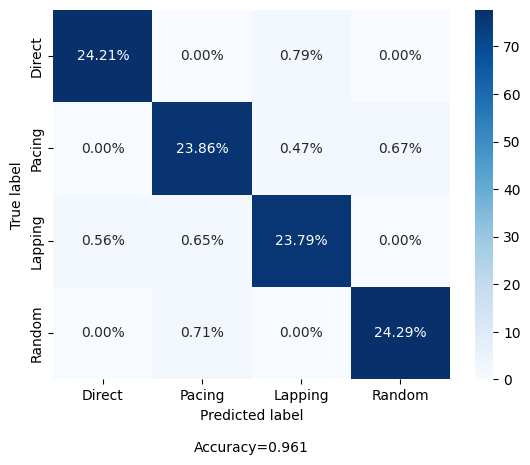

In [17]:
get_graph_matrix(RandomForestClassifier, time_series[2].data, labels)
plt.savefig('./figures/matrix_a.pdf')

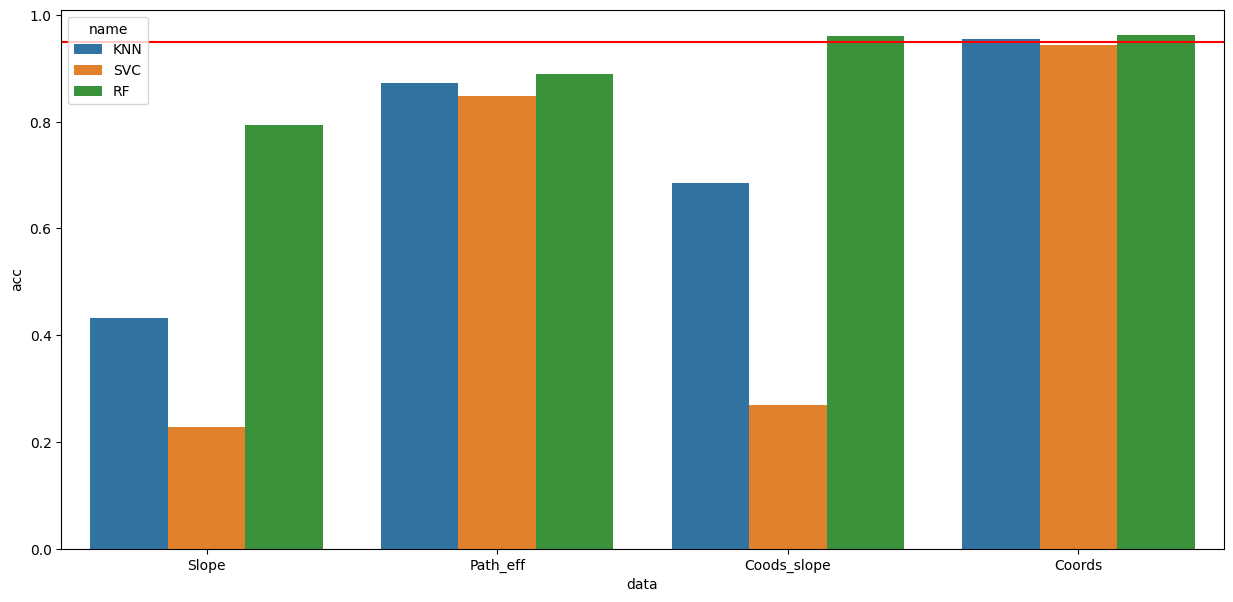

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

In [18]:
import seaborn as sns

plt.figure(figsize=[15,7])
bar_plot = sns.barplot(data=default_params, x='data', y='acc', hue='name')
bar_plot.axhline(0.95, color='red')